<a href="https://colab.research.google.com/github/govardhan-06/practice-Notebooks/blob/main/pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Pytorch Workflow

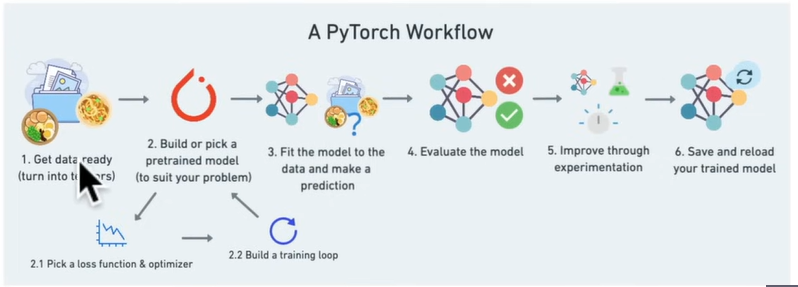

In [1]:
import torch
import torch.nn

#Version
torch.__version__

'2.3.0+cu121'

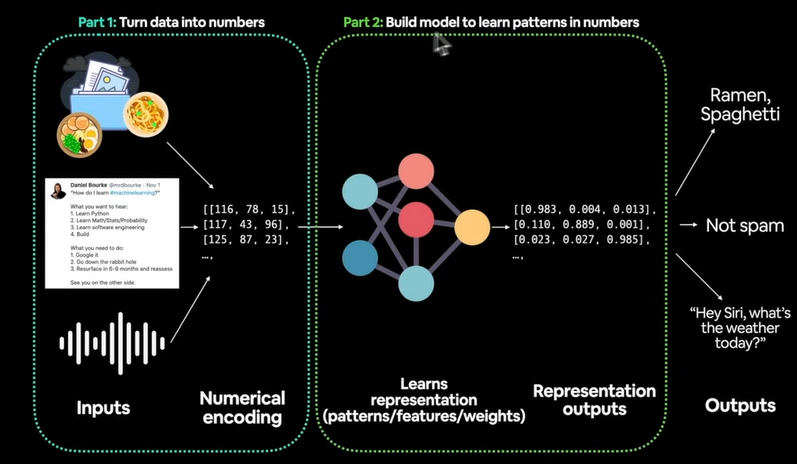

###Step 1. Data (preparing and loading)

* `simple linear regression` to make a straight line with known parameters

In [2]:
import torch

weight=0.7
bias=0.3

start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X),len(y)

(50, 50)

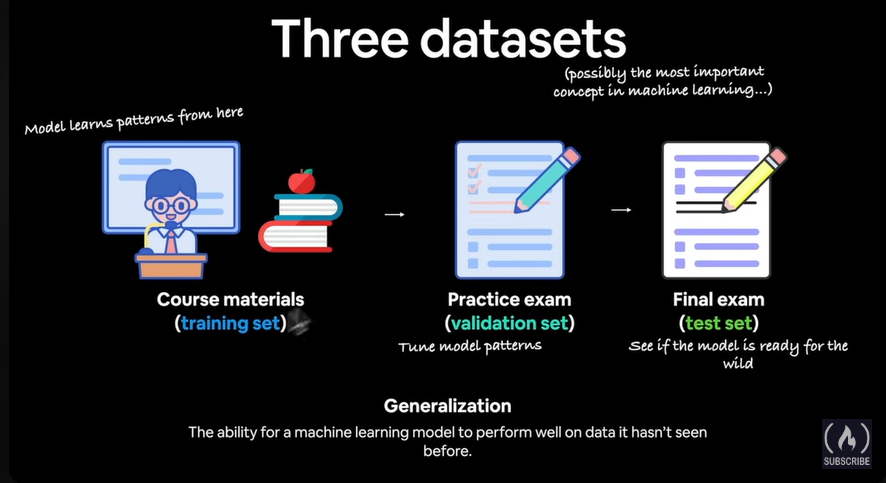

* `train-test split`

In [4]:
 from sklearn.model_selection import train_test_split

 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

* `data visulaization`

In [5]:
import matplotlib.pyplot as plt
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))

  #train_data plot
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  #test_data plot
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size":14})


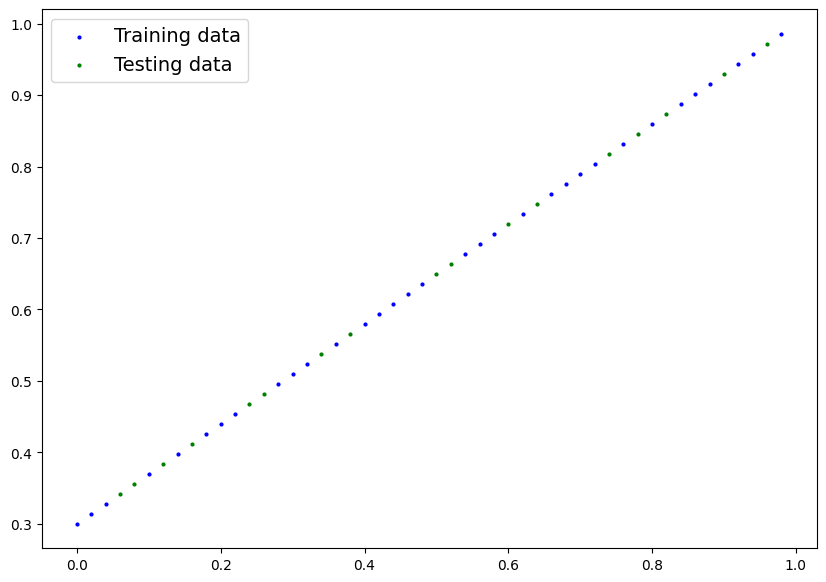

In [ ]:
plot_predictions();

### Building the pytorch model
* Inside the function:
* `x: torch.Tensor` means that the function expects data of type `torch.Tensor`
* `-> torch.Tensor` suggests that the function will return a `torch.Tensor` data

In [6]:
from torch import nn

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building essentials
* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` The base class for all neural network modules, if you subclass it, you should overwrite forward()
* `torch.optim` - this where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` All nn. Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

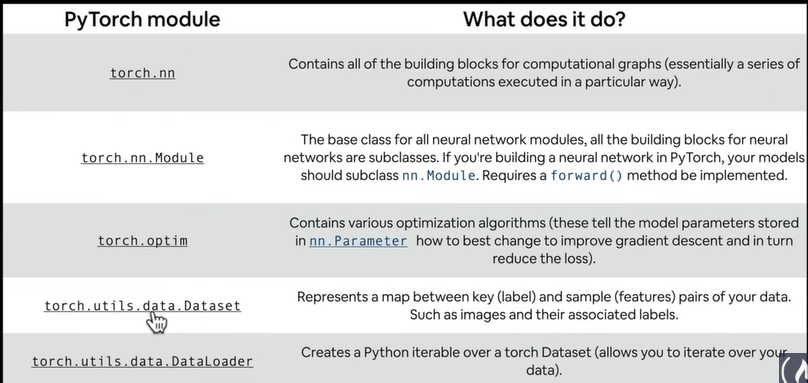

In [54]:
torch.manual_seed(42)

model=LinearRegressionModel()

list(model.parameters()) #returns the parameters

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [55]:
model.state_dict()  #model parameters

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [56]:
weight,bias  #known parameters

(0.7, 0.3)

###Prediction
* `torch.inference_mode()` : predicting the output of X_test data
* `y_preds=model(X_test)` : although this is also possible without the use of `inference_mode`, this is not a best practice

In [57]:
y_preds=model(X_test)
y_preds


##NOT USED COMMONLY, GO FOR inference_mode

tensor([[0.2163],
        [0.3914],
        [0.3308],
        [0.4318],
        [0.2433],
        [0.4520],
        [0.3039],
        [0.2972],
        [0.3443],
        [0.2568],
        [0.2096],
        [0.1557],
        [0.3780],
        [0.1827],
        [0.1490],
        [0.1692],
        [0.4049]], grad_fn=<AddBackward0>)

In [58]:
with torch.inference_mode():
  y_preds=model(X_test)

y_preds

tensor([[0.2163],
        [0.3914],
        [0.3308],
        [0.4318],
        [0.2433],
        [0.4520],
        [0.3039],
        [0.2972],
        [0.3443],
        [0.2568],
        [0.2096],
        [0.1557],
        [0.3780],
        [0.1827],
        [0.1490],
        [0.1692],
        [0.4049]])

In [59]:
y_test

tensor([[0.4820],
        [0.8460],
        [0.7200],
        [0.9300],
        [0.5380],
        [0.9720],
        [0.6640],
        [0.6500],
        [0.7480],
        [0.5660],
        [0.4680],
        [0.3560],
        [0.8180],
        [0.4120],
        [0.3420],
        [0.3840],
        [0.8740]])

* **Loss Function** : difference between the y_pred and y_test values
* **Optimizer** : it adjusts the weights and biases such that the data well fits the values

* `lr` is the learning rate, which is a hyperparameter, which is tuned by the developer itself

In [60]:
#picking up a loss function
loss_fn=nn.L1Loss()

#picking up an optimizer
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)

### Building a training loop (and a testing loop) in PyTorch
A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data also called forward propagation -
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward move backwards through the network to calculate the gradients of
each of the parameters of our model with respect to the loss (`backpropagation`)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (`gradient descent`)

In [61]:
torch.manual_seed(42)
#Training loop
epochs=120

for epoch in range(epochs):
  #training mode
  model.train()

  #1.forward pass
  y_pred=model(X_train)

  #2.loss
  loss=loss_fn(y_pred,y_train)

  #3.optimizer zero grad
  optimizer.zero_grad()

  #4.Backward propogation on the loss
  loss.backward()

  #5.optimizer step(performs gradient descent)
  optimizer.step()

  #6. Turns off gradient descent
  model.eval()

  print(loss)

tensor(0.3517, grad_fn=<MeanBackward0>)
tensor(0.3393, grad_fn=<MeanBackward0>)
tensor(0.3268, grad_fn=<MeanBackward0>)
tensor(0.3143, grad_fn=<MeanBackward0>)
tensor(0.3019, grad_fn=<MeanBackward0>)
tensor(0.2894, grad_fn=<MeanBackward0>)
tensor(0.2769, grad_fn=<MeanBackward0>)
tensor(0.2645, grad_fn=<MeanBackward0>)
tensor(0.2520, grad_fn=<MeanBackward0>)
tensor(0.2395, grad_fn=<MeanBackward0>)
tensor(0.2270, grad_fn=<MeanBackward0>)
tensor(0.2146, grad_fn=<MeanBackward0>)
tensor(0.2021, grad_fn=<MeanBackward0>)
tensor(0.1896, grad_fn=<MeanBackward0>)
tensor(0.1772, grad_fn=<MeanBackward0>)
tensor(0.1647, grad_fn=<MeanBackward0>)
tensor(0.1522, grad_fn=<MeanBackward0>)
tensor(0.1398, grad_fn=<MeanBackward0>)
tensor(0.1280, grad_fn=<MeanBackward0>)
tensor(0.1183, grad_fn=<MeanBackward0>)
tensor(0.1091, grad_fn=<MeanBackward0>)
tensor(0.1005, grad_fn=<MeanBackward0>)
tensor(0.0927, grad_fn=<MeanBackward0>)
tensor(0.0858, grad_fn=<MeanBackward0>)
tensor(0.0800, grad_fn=<MeanBackward0>)


* `optimizer.zero_grad()` it brings back gradient descent to zero
* `optimizer.step()` updates model parameters such that it better fits the  data

In [62]:
with torch.inference_mode():
  y_preds=model(X_test)

y_preds

tensor([[0.4912],
        [0.8389],
        [0.7185],
        [0.9192],
        [0.5447],
        [0.9593],
        [0.6650],
        [0.6517],
        [0.7453],
        [0.5714],
        [0.4778],
        [0.3708],
        [0.8122],
        [0.4243],
        [0.3574],
        [0.3975],
        [0.8657]])

In [63]:
y_test

tensor([[0.4820],
        [0.8460],
        [0.7200],
        [0.9300],
        [0.5380],
        [0.9720],
        [0.6640],
        [0.6500],
        [0.7480],
        [0.5660],
        [0.4680],
        [0.3560],
        [0.8180],
        [0.4120],
        [0.3420],
        [0.3840],
        [0.8740]])

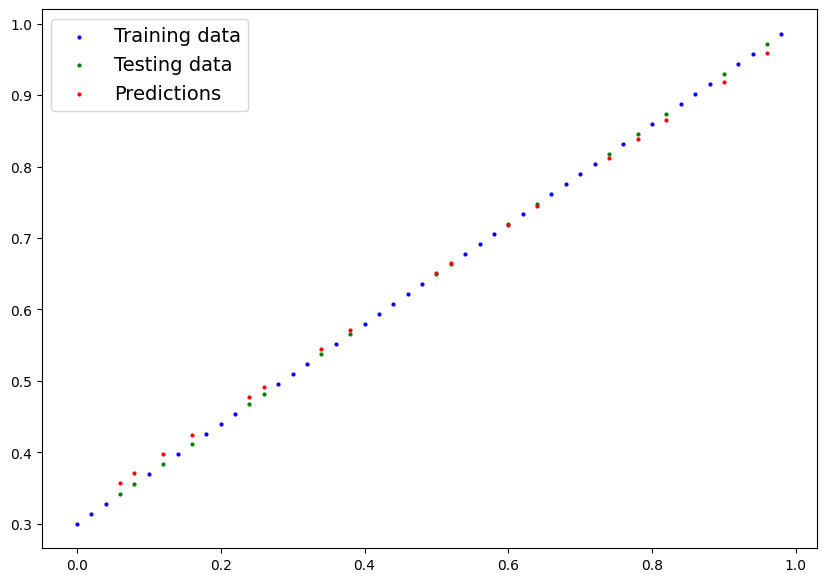

In [64]:
plot_predictions(predictions=y_preds)

###Testing loop

* `torch.inference_mode()` : turns off the different settings on the mdoel which are not needed for evaluation/testing
* `model.eval()` : intiates the model evaluation phase

In [65]:
for epoch in range(epochs):
  model.eval()

  with torch.inference_mode():
    y_pred=model(X_test)
    test_loss=loss_fn(y_pred,y_test)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model.state_dict)

Epoch: 0 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 10 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 20 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 30 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 40 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 50 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 60 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 70 | Loss: 0.00830745231360197 | Test loss: 0.00816437229514122
<bound method

In [66]:
y_pred  # after the testing stage

tensor([[0.4912],
        [0.8389],
        [0.7185],
        [0.9192],
        [0.5447],
        [0.9593],
        [0.6650],
        [0.6517],
        [0.7453],
        [0.5714],
        [0.4778],
        [0.3708],
        [0.8122],
        [0.4243],
        [0.3574],
        [0.3975],
        [0.8657]])

###Different Approach

In [72]:
torch.manual_seed(42)

model=LinearRegressionModel()

list(model.parameters()) #returns the parameters

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [73]:
#picking up a loss function
loss_fn=nn.L1Loss()

#picking up an optimizer
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)

In [74]:
torch.manual_seed(42)
#Training loop
epoch=200

#Training experiments
epoch_count=[]
loss_values=[]
test_loss_values=[]

for epoch in range(epochs):
  #training mode
  model.train()

  #1.forward pass
  y_pred=model(X_train)

  #2.loss
  loss=loss_fn(y_pred,y_train)

  #3.optimizer zero grad
  optimizer.zero_grad()

  #4.Backward propogation on the loss
  loss.backward()

  #5.optimizer step(performs gradient descent)
  optimizer.step()

  #6. Turns off gradient descent
  model.eval()

  with torch.inference_mode():
    y_pred=model(X_test)
    test_loss=loss_fn(y_pred,y_test)

  if epoch%10==0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model.state_dict)

Epoch: 0 | Loss: 0.35174450278282166 | Test loss: 0.3319290280342102
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 10 | Loss: 0.22704657912254333 | Test loss: 0.20824988186359406
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 20 | Loss: 0.10913042724132538 | Test loss: 0.09352266043424606
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 30 | Loss: 0.058310747146606445 | Test loss: 0.05630088597536087
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 40 | Loss: 0.046908315271139145 | Test loss: 0.04759702458977699
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 50 | Loss: 0.04141785204410553 | Test loss: 0.04257240891456604
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 60 | Loss: 0.036591459065675735 | Test loss: 0.03769758716225624
<bound method Module.state_dict of LinearRegressionModel()>
Epoch: 70 | Loss: 0.03179062530398369 | Test loss: 0.03271985799074173
<bound meth

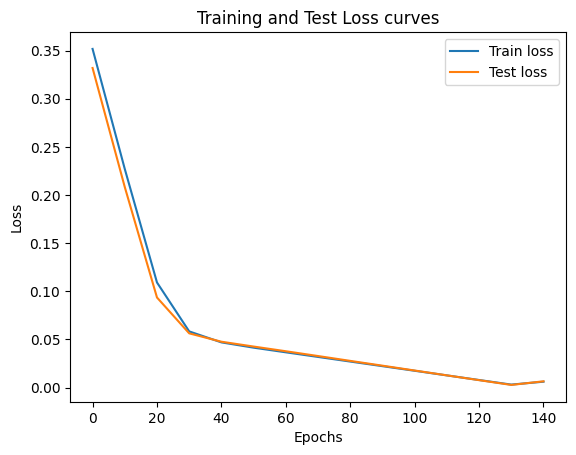

In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(epoch_count,np.array(loss_values),label="Train loss")
plt.plot(epoch_count,np.array(test_loss_values),label="Test loss")
plt.title("Training and Test Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

###Saving a model in PyTorch

In [76]:
from pathlib import Path

# 1. Creating directory
MODEL_PATH=Path("models")
#even if the folder already there, it won't return an error
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Creating a model save path
MODEL_NAME="pytorch_model_1.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

# 3. Save the model state.dict
#Recommended way of saving ; Check docs for different approaches
print(f"Model getting saved to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_PATH/MODEL_NAME)

Model getting saved to models/pytorch_model_1.pth


In [77]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1544 Jun 14 02:35 pytorch_model_1.pth
